In [293]:
# importing essential libraries
import warnings
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs
from mpl_toolkits.mplot3d import Axes3D
warnings.filterwarnings("ignore", category=RuntimeWarning)

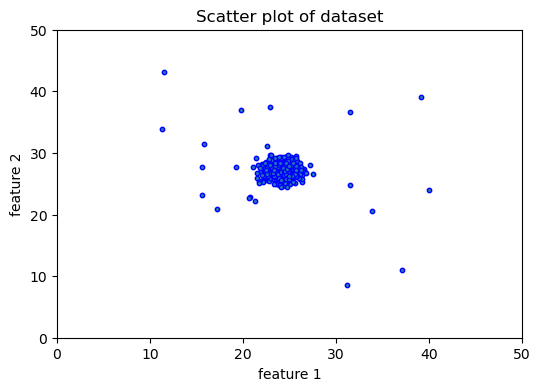

In [294]:
# creating the dataset
X, y = make_blobs(n_samples=600, n_features=2, centers=1, cluster_std=1, center_box=(20.0, 30.0), shuffle=True, random_state=1)
X_, y_ = make_blobs(n_samples=20, n_features=2, centers=1, cluster_std=10, center_box=(10.0, 40.0), shuffle=True, random_state=1)

x1 = [i[0] for i in X]
x2 = [i[1] for i in X]
x1_ = [i[0] for i in X_]
x2_ = [i[1] for i in X_]

fig, ax = plt.subplots(1, 1, figsize=(6, 4))
ax.scatter(x1+x1_, x2+x2_, alpha=1, s=10, edgecolor='b')
ax.set_title("Scatter plot of dataset")
ax.set_xlabel("feature 1")
ax.set_ylabel("feature 2")
ax.set_xlim(0, 50)
ax.set_ylim(0, 50)
plt.show()

Shape of the training dataset: (400, 2)
Shape of the validation dataset: (110, 2)
Shape of the test dataset: (110, 2)


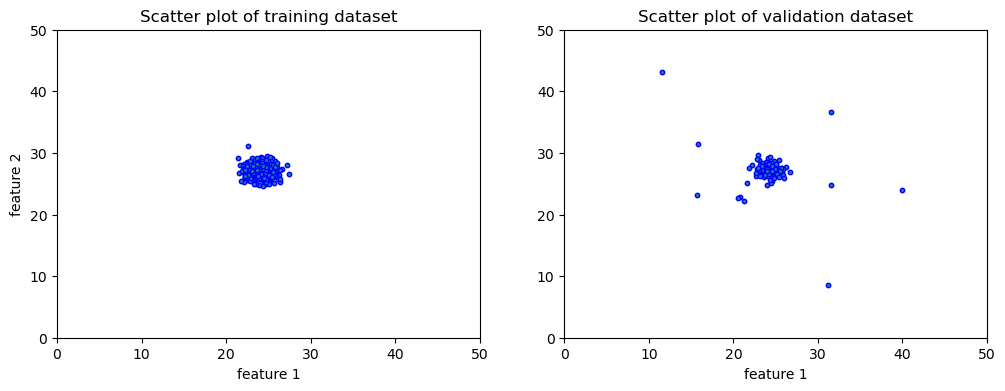

In [295]:
# seperating the train, validation and test datasets
X_train = X[:400]
X_val = np.vstack((X[400:500], X_[:10]))
X_test = np.vstack((X[500:], X_[10:]))
print("Shape of the training dataset:", X_train.shape)
print("Shape of the validation dataset:", X_val.shape)
print("Shape of the test dataset:", X_test.shape)

X_train_1 = [i[0] for i in X_train]
X_train_2 = [i[1] for i in X_train]
X_val_1 = [i[0] for i in X_val]
X_val_2 = [i[1] for i in X_val]
y_val = np.hstack((y[400:500], np.array([1 for i in range(10)])))
y_test = np.hstack((y[500:], np.array([1 for i in range(10)])))

fig, ax = plt.subplots(1, 2, figsize=(12, 4))
ax[0].scatter(X_train_1, X_train_2, alpha=1, s=10, edgecolor='b')
ax[0].set_title("Scatter plot of training dataset")
ax[0].set_xlabel("feature 1")
ax[0].set_ylabel("feature 2")
ax[0].set_xlim(0, 50)
ax[0].set_ylim(0, 50)
ax[1].scatter(X_val_1, X_val_2, alpha=1, s=10, edgecolor='b')
ax[1].set_title("Scatter plot of validation dataset")
ax[1].set_xlabel("feature 1")
ax[0].set_ylabel("feature 2")
ax[1].set_xlim(0, 50)
ax[1].set_ylim(0, 50)
plt.show()

In [296]:
# defining the function to get the covariance value for two variables
def covariance(X, mu, idx_1, idx_2):
    v1 = [k[idx_1] for k in X]
    v2 = [k[idx_2] for k in X]
    cov = 0
    m = X.shape[0]
    for i in range(m):
        cov += (v1[i]-mu[idx_1])*(v2[i]-mu[idx_2])
    cov = cov / m
    return cov

In [297]:
# defining the function to get the variance covariance matrix for a dataset when given with means
def covariance_matrix(X, mu):
    d = X.shape[1]
    sigma = np.zeros((d, d))
    for i in range(d):
        for j in range(d):
            cov = covariance(X, mu, i, j)
            sigma[i][j] = cov
    return sigma

In [298]:
# defining the function to get a value of a point in multivariate distribution curve
def multivariate_equation(X, mu, sigma, d):
    f = (1/((2*np.pi)**(d/2)*np.linalg.det(sigma)**(0.5)))*np.exp(-0.5*(X-mu)@np.linalg.inv(sigma)@np.transpose(X-mu))
    return f

In [299]:
# defining the function to output probability values according to the multivariate distribution
def multivariate_gaussian(X, mu, sigma):
    m, d = X.shape
    p_val = np.zeros(m)
    for k in range(m):
        x = X[k]
        f = multivariate_equation(x, mu, sigma, d)
        p_val[k] = f
    return p_val

In [300]:
# defining the function for extracting the means and variances from all the features
def estimate_gaussian(X): 
    m, n = X.shape
    mu = np.zeros(n,)
    var = np.zeros(n,)
    
    for i in range(n):
        mu_ = 0
        for j in range(m):
            mu_ += X[j][i]
        mu_ /= m
        mu[i] = mu_
        
    for i in range(n):
        var_ = 0
        for j in range(m):
            var_ += (X[j][i] - mu[i])**2
        var_ /= m
        var[i] = var_ 
        
    return mu, var

In [301]:
# defining the function to find the best epsilon and the best F1 score
def select_threshold(y_val, p_val): 
    best_epsilon = 0
    best_F1 = 0
    F1 = 0  
    step_size = (max(p_val) - min(p_val)) / 1000
    
    for epsilon in np.arange(min(p_val), max(p_val), step_size):
        pred_val = np.zeros(p_val.shape, dtype=int)
        
        for i in range(len(p_val)):
            if (p_val[i] < epsilon):
                pred_val[i] = 1
            else:
                pred_val[i] = 0
                
        tp = sum(y_val & pred_val)
        fp = sum((y_val^1) & pred_val)
        fn = sum(y_val & (pred_val^1))
        prec = tp / (tp + fp)
        rec = tp / (tp + fn)
        F1 = (2 * prec * rec) / (prec + rec)
        if F1 > best_F1:
            best_F1 = F1
            best_epsilon = epsilon
        
    return best_epsilon, best_F1

In [302]:
# finding the best epsilon and the best F1 score
mu, var = estimate_gaussian(X_train)
sigma = covariance_matrix(X_train, mu)
p_val = multivariate_gaussian(X_val, mu, sigma)
epsilon, F1 = select_threshold(y_val, p_val)

print('Best epsilon found using cross-validation: %e' % epsilon)
print('Best F1 on Cross Validation Set: %f' % F1)

Best epsilon found using cross-validation: 1.617547e-04
Best F1 on Cross Validation Set: 1.000000


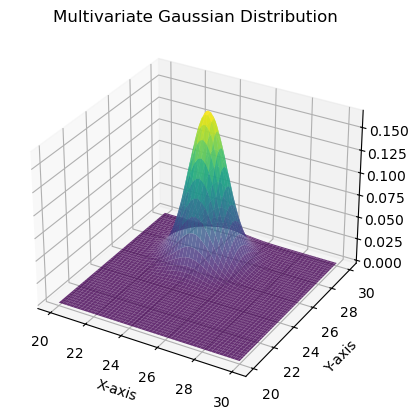

In [303]:
# ploting the multivariate distribution curve for the parameters of the training dataset
x = np.linspace(20, 30, 100)
y = np.linspace(20, 30, 100)
X, Y = np.meshgrid(x, y)
grid_points = np.column_stack((X.ravel(), Y.ravel()))
d = 2
num_points = grid_points.shape[0]
pdf_values = np.zeros(num_points)
for h in range(num_points):
    pdf_value = multivariate_equation(grid_points[h], mu, sigma, d)
    pdf_values[h] = pdf_value
pdf_values = pdf_values.reshape(X.shape)
fig = plt.figure(figsize=(4, 6))
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(X, Y, pdf_values, cmap='viridis', alpha=0.8)
ax.set_xlabel('X-axis')
ax.set_ylabel('Y-axis')
ax.set_title('Multivariate Gaussian Distribution')
fig.tight_layout()
plt.show()

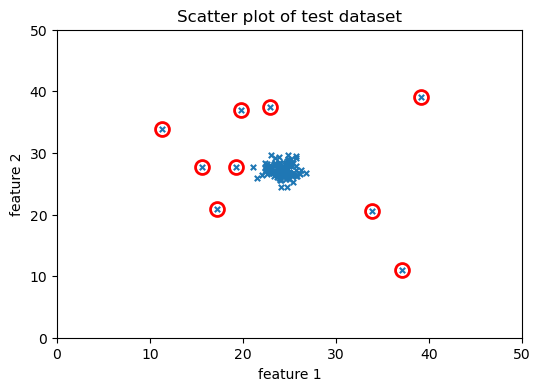

In [304]:
# detecting anomalies for the test dataset
p_test = multivariate_gaussian(X_test, mu, sigma)
outliers = p_test < epsilon
fig, ax = plt.subplots(1, 1, figsize=(6, 4))
ax.scatter(X_test[:, 0], X_test[:, 1], marker='x', s=15)
ax.plot(X_test[outliers, 0], X_test[outliers, 1], 'ro', markersize= 10, markerfacecolor='none', markeredgewidth=2)
ax.set_title("Scatter plot of test dataset")
ax.set_xlabel("feature 1")
ax.set_ylabel("feature 2")
ax.set_xlim(0, 50)
ax.set_ylim(0, 50)
plt.show()